In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np



%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

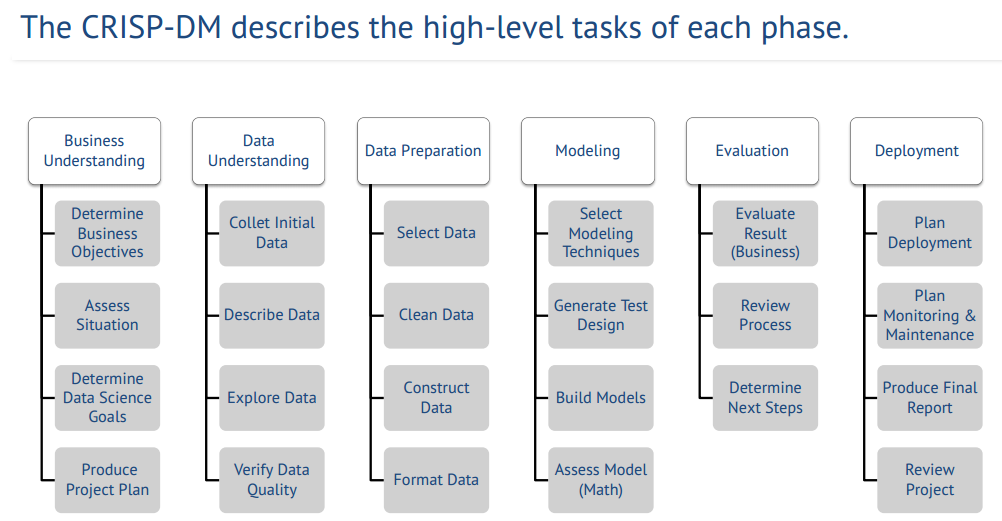

## Data load

In [10]:
df_analyse=pd.read_csv('../data/processed/COVID_small_sync_timeline_table.csv',sep=';')  

df_analyse.sort_values('date',ascending=True).head()

,doubling every two days,doubling every 4 days,doubling every 10 days,Italy,US,Spain,Germany,"Korea, South",date
0,100.000000,100.000000,100.000000,155.0,118.0,120.0,130.0,104.0,0
1,141.421356,118.920712,107.177346,229.0,149.0,165.0,159.0,204.0,1
2,200.000000,141.421356,114.869835,322.0,217.0,222.0,196.0,433.0,2
3,282.842712,168.179283,123.114441,453.0,262.0,259.0,262.0,602.0,3
4,400.000000,200.000000,131.950791,655.0,402.0,400.0,482.0,833.0,4


In [11]:
country_list = df_analyse.columns[1:]

## Helper functions

In [12]:
def quick_plot(x_in, df_input,y_scale='log',slider=False):
    """ Quick basic plot for quick static evaluation of a time series
    
        you can push selective columns of your data frame by .iloc[:,[0,6,7,8]]
        
        Parameters:
        ----------
        x_in : array 
            array of date time object, or array of numbers
        df_input : pandas dataframe 
            the plotting matrix where each column is plotted
            the name of the column will be used for the legend
        scale: str
            y-axis scale as 'log' or 'linear'
        slider: bool
            True or False for x-axis slider
    
        
        Returns:
        ----------
        
    """
    fig = go.Figure()

    for each in df_input.columns:
        fig.add_trace(go.Scatter(
                        x=x_in,
                        y=df_input[each],
                        name=each,
                        opacity=0.8))
    
    fig.update_layout(autosize=True,
        width=1024,
        height=768,
        font=dict(
            family="PT Sans, monospace",
            size=18,
            color="#7f7f7f"
            )
        )
    fig.update_yaxes(type=y_scale),
    fig.update_xaxes(tickangle=-45,
                 nticks=20,
                 tickfont=dict(size=14,color="#7f7f7f")
                )
    if slider==True:
        fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()
      

In [14]:
quick_plot(df_analyse.date,
           df_analyse.iloc[:,3:-1],
           y_scale='log',
           slider=True)

## Fitting a polynomial curve

In [15]:
# check that all data are there
df_poly_check=df_analyse.iloc[0:27,3:-1].reset_index()
df_poly_check.head()

,index,Italy,US,Spain,Germany,"Korea, South"
0,0,155.0,118.0,120.0,130.0,104.0
1,1,229.0,149.0,165.0,159.0,204.0
2,2,322.0,217.0,222.0,196.0,433.0
3,3,453.0,262.0,259.0,262.0,602.0
4,4,655.0,402.0,400.0,482.0,833.0


In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [17]:
y=df_poly_check[['Germany','Italy','US','Spain']].unstack().sort_index(axis=0,level=1)

In [19]:
y

Germany  0        130.0
Italy    0        155.0
US       0        118.0
Spain    0        120.0
Germany  1        159.0
Italy    1        229.0
US       1        149.0
Spain    1        165.0
Germany  2        196.0
Italy    2        322.0
US       2        217.0
Spain    2        222.0
Germany  3        262.0
Italy    3        453.0
US       3        262.0
Spain    3        259.0
Germany  4        482.0
Italy    4        655.0
US       4        402.0
Spain    4        400.0
Germany  5        670.0
Italy    5        888.0
US       5        518.0
Spain    5        500.0
Germany  6        799.0
Italy    6       1128.0
US       6        583.0
Spain    6        673.0
Germany  7       1040.0
Italy    7       1694.0
US       7        959.0
Spain    7       1073.0
Germany  8       1176.0
Italy    8       2036.0
US       8       1281.0
Spain    8       1695.0
Germany  9       1457.0
Italy    9       2502.0
US       9       1663.0
Spain    9       2277.0
Germany  10      1908.0
Italy    10     

In [20]:
test_points=28
y_train=y[0:-test_points-1]
y_test=y[-test_points:]

In [21]:
X_train=np.arange(len(y_train)).reshape(-1, 1)/4.0 
X_test=np.arange(len(y_train),len(y_train)+test_points).reshape(-1, 1)/4.0

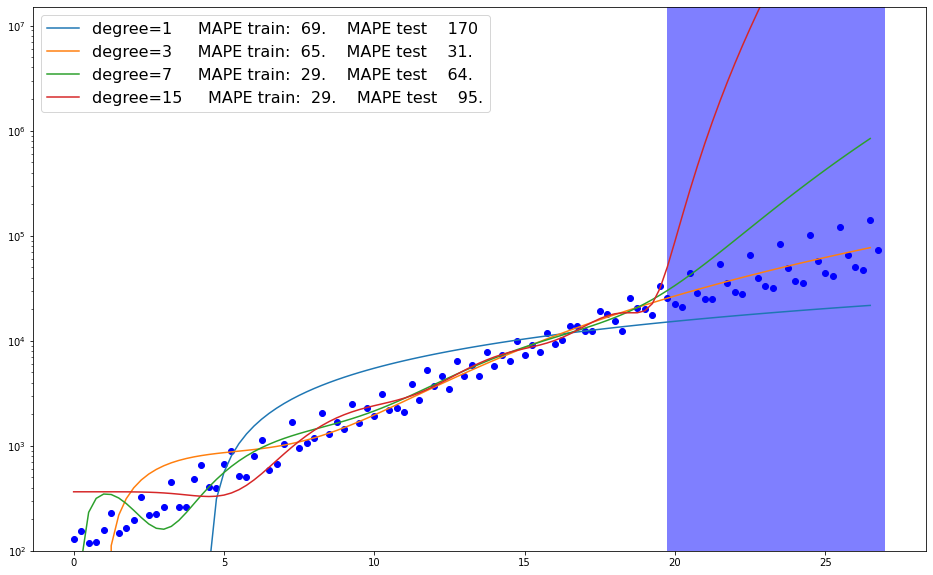

In [23]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(np.
            arange(len(y))/4,y, color='blue')
ax1.axvspan((len(y)-test_points-1)/4, len(y)/4, facecolor='b', alpha=0.5)

for degree in [1,3,7,15]:
    y_hat_insaple=PolynomialRegression(degree).fit(X_train, y_train).predict(X_train)
    y_hat_test = PolynomialRegression(degree).fit(X_train, y_train).predict(X_test)



    X_plot=np.concatenate((X_train, X_test), axis=None)
    y_plot=np.concatenate((y_hat_insaple, y_hat_test), axis=None)

    ax1.plot(X_plot, y_plot, label='degree={0}'.format(degree)+ 
                 '     MAPE train:  ' + str(mean_absolute_percentage_error(y_hat_insaple, y_train))[0:3]
                 +'    MAPE test    ' +str(mean_absolute_percentage_error(y_hat_test, y_test))[0:3]) 

ax1.set_ylim(100, 15000000)
ax1.set_yscale('log')
ax1.legend(loc='best',
           prop={'size': 16});

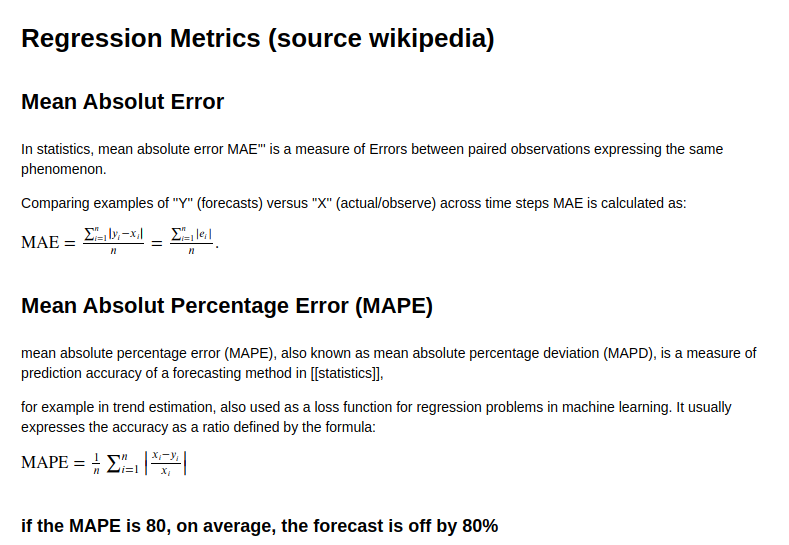

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

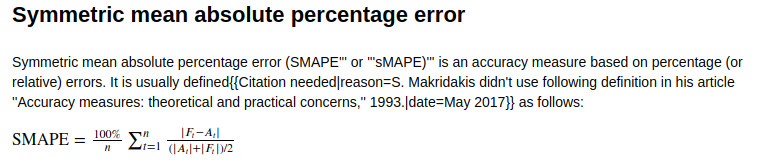